# Measure computational efficiency

Measure efficiency to compute each of the tested shape metrics. While one may be significantly better than the others, it is of no use if it is not efficient enough.

In [29]:
import warnings
import time
from collections import defaultdict
import os

os.environ["USE_PYGEOS"] = "0"

import geopandas
import pandas
import dask_geopandas
import numpy
import esda.shape as shape
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from palettable.cartocolors.qualitative import Bold_6

from tqdm import tqdm

Set default plotting theme.

In [10]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

Load the data and combine them to a single GeoDataFrame.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)

Measure performance of each metric on a random sample of 10 000 polygons. Given the nature of the computation, there's no need to test other sample sizes as the relationship between performance and size is linear.

In [4]:
times = {}
for c in [
    "circular_compactness",
    "isoperimetric_quotient",
    "isoareal_quotient",
    "radii_ratio",
    "diameter_ratio",
]:
    times[c] = []
sample = all_poly_data.sample(10000, random_state=42)
ga = sample.geometry.values.data
for _ in range(100):
    s = time.time()
    r = shape.minimum_bounding_circle_ratio(ga)
    times["circular_compactness"].append(time.time() - s)

    s = time.time()
    r = shape.isoperimetric_quotient(ga)
    times["isoperimetric_quotient"].append(time.time() - s)

    s = time.time()
    r = shape.radii_ratio(ga)
    times["radii_ratio"].append(time.time() - s)

    s = time.time()
    r = shape.isoareal_quotient(ga)
    times["isoareal_quotient"].append(time.time() - s)

    s = time.time()
    r = shape.diameter_ratio(ga)
    times["diameter_ratio"].append(time.time() - s)

In [5]:
perf = pandas.DataFrame(times)
perf.to_csv("../results/performance.csv")

In [18]:
perf = pandas.read_csv("../results/performance.csv", index_col=0)

Plot time for each run.

In [19]:
perf.columns = [c.replace("_", " ") for c in perf.columns]

<AxesSubplot: >

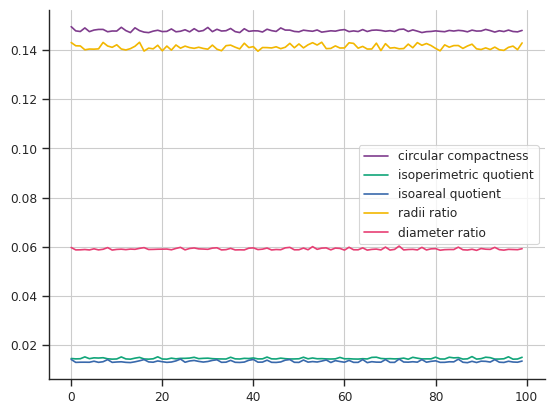

In [20]:
perf.plot()

Plot results as a box plot.

<AxesSubplot: >

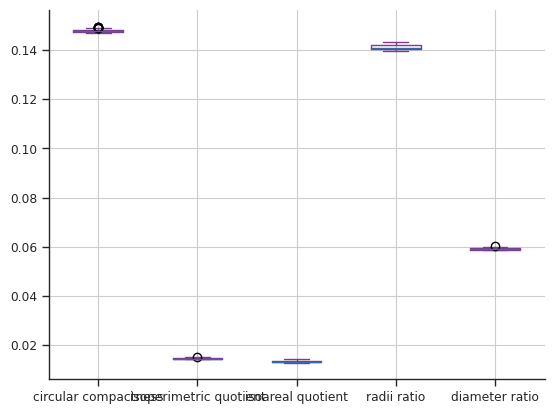

In [23]:
perf.plot.box()

Box plot with logged Y axis.

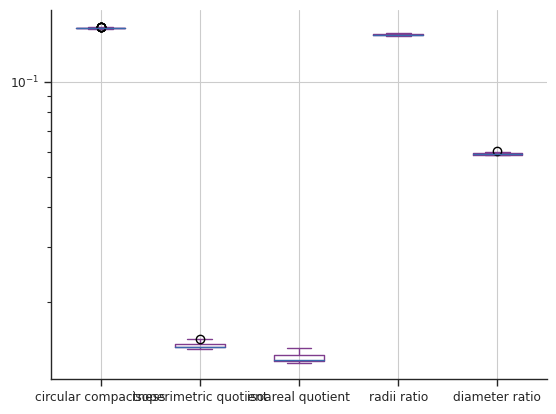

In [24]:
perf.plot.box().set_yscale("log")

Mean time to measure 10k polygons.

In [31]:
rcParams.update({"figure.autolayout": True})

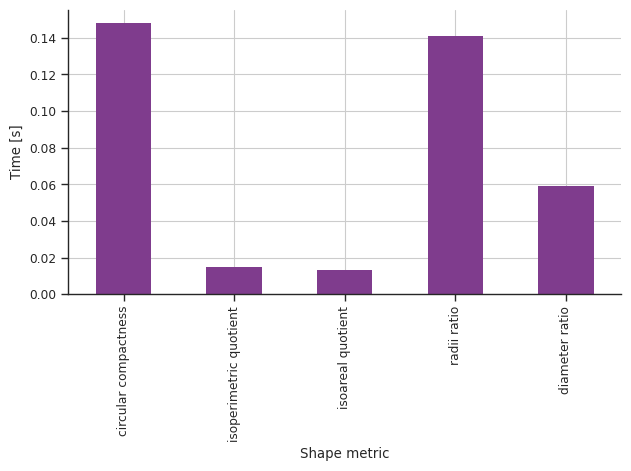

In [35]:
fig, ax = plt.subplots(1, 1)

means = perf.mean()
means.plot.bar()
ax.set_xlabel("Shape metric")
ax.set_ylabel("Time [s]")
plt.savefig("../plots/shapes/performance.png", dpi=300, bbox_inches="tight")

In [37]:
means / means.min()

circular compactness      11.075945
isoperimetric quotient     1.093380
isoareal quotient          1.000000
radii ratio               10.578285
diameter ratio             4.424829
dtype: float64

In [ ]:
means

circular compactness      0.147904
isoperimetric quotient    0.014601
isoareal quotient         0.013354
radii ratio               0.141259
diameter ratio            0.059088
dtype: float64